In [148]:
import os
import sys
# import tensorflow_hub as hub
import pandas as pd
# Root directory of the project
ROOT_DIR = os.path.abspath("../")
# Import maskRCNN
sys.path.append(ROOT_DIR)
import geopandas as gpd
import DataProcessing as DP
import json
import skimage
from tqdm import tqdm
import rasterio
from itertools import product
from rasterio import windows
import DataProcessing as DP
from pathlib import Path
import rioxarray
import shapely
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [54]:
# opencity ai dataset
data_path = os.path.join(ROOT_DIR, "datasets", "open_cities_ai_challenge_train_tier_1_source")
label_path = os.path.join(ROOT_DIR, "datasets", "open_cities_ai_challenge_train_tier_1_labels")
 
data_dict = dict()
    
for data in os.listdir(data_path):
    
    if "json" not in data:
        
        if "image" not in data_dict:
            data_dict["image"] = list()
            data_dict["label"] = list()
        else:
            data_dict["image"].append(os.path.join(data_path, data, "image.tif"))
            data_dict["label"].append(os.path.join(label_path, data, "labels.geojson"))

In [146]:
def get_tiles(ds, width=256, height=256):
    nols, nrows = ds.meta['width'], ds.meta['height']
    offsets = product(range(0, nols, width), range(0, nrows, height))
    big_window = windows.Window(col_off=0, row_off=0, width=nols, height=nrows)
    for col_off, row_off in offsets:
        window =windows.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
        transform = windows.transform(window, ds.transform)
        yield window, transform
        
    
def re_projection(intif, outtif, dst_crs=None):
    
    if dst_crs is None:
        
        dst_crs = 'EPSG:4326'
    
    src = rasterio.open(intif)
    transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    
    with rasterio.open(outtif, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

In [40]:
out = os.path.join(ROOT_DIR, "processing_data/clipped")

In [42]:

gen_patches = False
# IMAGE_PATH, POLY_PATH
N = 1024
num = 0

while gen_patches:
    gen_patches = False
    for tile in tqdm(data_dict["image"]):

        tile_path = tile

        print("------------------------------------------------------")

        print("Processing tile {}: ".format(tile_path))

        num += 1
        print("Image {}".format(str(num)))

        tile_name = os.path.basename(os.path.dirname(tile_path))
        output_filename = tile_name + '_tile_{}-{}.tif'

        with rasterio.open(tile_path) as inds:

            meta = inds.meta.copy()

            for window, transform in get_tiles(inds, N, N):

                meta['transform'] = transform
                meta['width'], meta['height'] = window.width, window.height

                Path(out, tile_name).mkdir(exist_ok=True, parents=True)

                outpath = os.path.join(out, tile_name, output_filename.format(int(window.col_off), int(window.row_off)))

                with rasterio.open(outpath, 'w', **meta) as outds:
                    outds.write(inds.read(window=window))

In [155]:
# Project to wgs 84
project_out = os.path.join(ROOT_DIR, "processing_data/projected")
crop_path = os.path.join(ROOT_DIR, "processing_data", "clipped")

for data in os.listdir(crop_path):
    
    Path(ROOT_DIR, "processing_data", "projected", data).mkdir(exist_ok=True, parents=True)
    
    if os.path.isdir(os.path.join(crop_path, data)):
    
        datalist = [subdata for subdata in os.listdir(os.path.join(crop_path, data)) if subdata.endswith(".tif")]
        
        data_path = 

        




IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [67]:

# generate labels

Path(os.path.join(ROOT_DIR, "processing_data", "annotations")).mkdir(exist_ok=True, parents=True)

for tile in tqdm(data_dict["image"][0:2]):
    
    img_tile_name = os.path.basename(os.path.dirname(tile))
    label_tile_name = img_tile_name.replace("source", "labels")
    
    imgs = [img for img in os.listdir(Path(ROOT_DIR) / "processing_data" / "clipped" / img_tile_name) if img.endswith(".tif")]

    # Create an annotation folder
    Path(os.path.join(ROOT_DIR, "processing_data", "annotations", label_tile_name)).mkdir(exist_ok=True, parents=True)
    
    # new annotation path
    annotation_path = Path(ROOT_DIR) / "processing_data" / "annotations" / label_tile_name / "annotations.json"
    
    # read label geojson
    label_gdf = gpd.read_file(os.path.join(label_path, label_tile_name, "labels.geojson"))


    for img in imgs:
        
        img_path = Path(ROOT_DIR) / "processing_data" / "clipped" / img_tile_name / img

        try:
            img_src = rasterio.open(img_path)
            width = img_src.width
            height = img_src.height
        except:
            print(img_path)
            raise

        bound_xmin, bound_ymin, bound_xmax, bound_ymax = img_src.bounds
        img_bound = shapely.geometry.box(bound_xmin, bound_ymin, bound_xmax, bound_ymax, ccw=True)


        overlap_gdf = label_gdf[label_gdf.intersects(img_bound)]
        
        if not overlap_gdf.empty:
            print(overlap_gdf)

#         generate_annotation(img_path, poly_geos, label)

#         outmeta['img_path'].append(img_path)
#         outmeta['poly_ids'].append(poly_ids)



  0%|          | 0/2 [04:05<?, ?it/s]


KeyboardInterrupt: 

In [129]:
testlabel = "/rapids/notebooks/sciclone/geograd/Miranda/github/Building_Detection_CN/datasets/open_cities_ai_challenge_train_tier_1_labels/open_cities_ai_challenge_train_tier_1_labels_dar_42f235/labels.geojson"

In [130]:
testgdf = gpd.read_file(testlabel)

In [131]:
imgfile = "/rapids/notebooks/sciclone/geograd/Miranda/github/Building_Detection_CN/test.tif"

In [132]:
from rasterio.plot import show
src = rasterio.open(imgfile)
img_array = src.read()


/opt/conda/envs/rapids/lib/python3.7/site-packages/rasterio/plot.py:107: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  arr = source.read(rgb_indexes, masked=True)


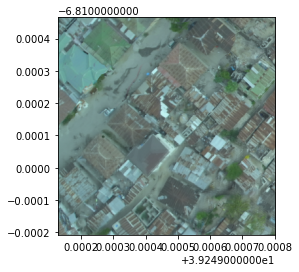

<AxesSubplot:>

In [134]:
show(src)

In [135]:
bound_xmin, bound_ymin, bound_xmax, bound_ymax = src.bounds
img_bound = shapely.geometry.box(bound_xmin, bound_ymin, bound_xmax, bound_ymax, ccw=True)

overlap_gdf = testgdf[testgdf.intersects(img_bound)]


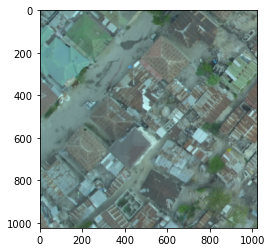

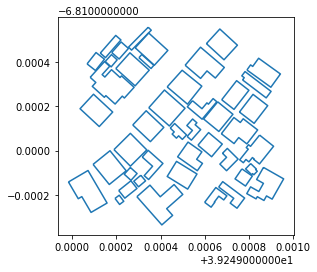

In [145]:
import numpy as np
from matplotlib import pyplot as plt

f, ax = plt.subplots()

# plot DEM
rasterio.plot.show(
    src.read(),  # use tiff.read(1) with your data
    ax=ax
)
# plot shapefiles
overlap_gdf.boundary.plot()
plt.show()